# CUHK [STAT3009](https://www.bendai.org/STAT3009/) Notebook9: Side information: continuous and discrete features

## Pre-process the ML-100K raw data
- check the `user_id` and `item_id`: mapping `item_id` to a continuous sequence based on `sklean.preprocessing`
- use `sklearn.model_selection.train_test_split` to generate `train` and `test` dataset

## Load additional ``side information``

ref: https://colab.research.google.com/github/lcharlin/80-629/blob/master/week4-PracticalSession/Introduction_to_ML.ipynb#scrollTo=4R717-S52plZ

In [24]:
import numpy as np
import pandas as pd
# load rating
df = pd.read_csv('./dataset/ml-latest-small/ratings.csv')
del df['timestamp']

movies_pd = pd.read_csv('./dataset/ml-latest-small/movies.csv', sep=',', engine='python')
movies_pd.sample(10)

,movieId,title,genres
4446,6565,Seabiscuit (2003),Drama
6013,37853,Into the Blue (2005),Action|Adventure|Crime|Thriller
1305,1748,Dark City (1998),Adventure|Film-Noir|Sci-Fi|Thriller
9062,142222,Demolition (2016),Drama
5667,27627,Oasis (2002),Drama|Romance
5134,8228,"Maltese Falcon, The (a.k.a. Dangerous Female) ...",Mystery
7830,93114,Ro.Go.Pa.G. (1963),Comedy|Drama
7947,95873,Ruby Sparks (2012),Comedy|Fantasy|Romance
4119,5909,Visitor Q (Bizita Q) (2001),Comedy|Drama|Horror
4533,6720,Kuffs (1992),Action|Comedy|Crime


## Feature engineering
- extract `year` and `genre` from the movies' side information
- For simplicity, if multiple genres exist, we just take the first one
- `Regex` to deal with the raw data [tutorial](https://regexone.com/) 

In [25]:
import re

year, genre = [], []
for i in range(len(movies_pd)):
	row = movies_pd.loc[i]
	year_tmp = re.findall('\d+', row['title'])
	if len(year_tmp) > 0:
		year.append(int(year_tmp[0]))
	else:
		year.append(np.nan)
	## take the first one as primary genere
	genre.append(row['genres'].split('|')[0])

movies_pd['year'], movies_pd['pGenre'] = year, genre
## delete original title and genres
del movies_pd['title']
del movies_pd['genres']
movies_pd.sample(10)

,movieId,year,pGenre
4529,6711,2003.0,Comedy
6318,48560,2006.0,Comedy
9594,175585,2017.0,Action
8176,102823,2000.0,Documentary
3132,4215,1987.0,Comedy
2010,2676,1999.0,Drama
3411,4640,2000.0,Action
670,882,1996.0,Drama
529,618,1995.0,Comedy
2137,2844,1999.0,Drama


## [Missing data](https://machinelearningmastery.com/handle-missing-data-python/)
- Usually we impute the missing values by average, but there are some fancy methods, see [Imputation of missing values](https://scikit-learn.org/stable/modules/impute.html#impute).
- Use package `sklearn.impute.SimpleImputer`

In [26]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(movies_pd['year'].values.reshape(-1, 1))
movies_pd['year'] = imp_mean.transform(movies_pd['year'].values.reshape(-1, 1))

## Generate some additional side information for users and items
- Number of ratings
- Averaged ratings
- quantiles of the ratings (as a practice)

In [27]:
user_pd = pd.merge(left=df.groupby('userId')['rating'].mean(), 
					right=df.groupby('userId')['rating'].count(), on='userId', )
user_pd.columns = ['rating_mean', 'rating_count']
user_pd = user_pd.reset_index()

movie_rating_pd = pd.merge(left=df.groupby('movieId')['rating'].mean(), 
						right=df.groupby('movieId')['rating'].count(), on='movieId')
movie_rating_pd.columns	= ['rating_mean', 'rating_count']

movies_pd = pd.merge(left=movie_rating_pd, right=movies_pd, on='movieId')

print(user_pd.sample(10))
print(movies_pd.sample(10))

     userId  rating_mean  rating_count
17       18     3.732072           502
373     374     3.636364            33
36       37     4.142857            21
33       34     3.418605            86
359     360     3.360000            25
252     253     4.351064            47
598     599     2.642050          2478
92       93     4.288660            97
150     151     3.542373            59
241     242     3.600000            35
      movieId  rating_mean  rating_count    year       pGenre
3842     5404     4.500000             3    84.0        Drama
6894    64116     3.500000             2  2008.0    Animation
1935     2567     2.973684            19  1999.0       Comedy
5937    34397     3.000000             1  2001.0       Action
9194   151759     2.500000             1  2015.0  Documentary
2894     3879     2.000000             2  2000.0       Action
5898    33725     3.166667             3  2004.0       Comedy
4070     5816     3.598039           102  2002.0    Adventure
1267     1683

## Pre-processing the dataset
- all continuous features should be standardized as mean 0, std 1
- all categorical features should be re-encoding to remove the missing ones

In [28]:
from sklearn import preprocessing
## pre-processing for users
user_cont = ['rating_mean', 'rating_count']
user_pd[user_cont] = preprocessing.StandardScaler().fit_transform(user_pd[user_cont])

## pre-processing for movies
movie_cont = ['rating_mean', 'rating_count', 'year']
movies_pd[movie_cont] = preprocessing.StandardScaler().fit_transform(movies_pd[movie_cont])

## encoding for categorical data 
from sklearn import preprocessing
le_genre = preprocessing.LabelEncoder()
movies_pd['pGenre'] = le_genre.fit_transform(movies_pd['pGenre'])

## joint encoding for userId and movieId
# !!! all dfs should share the same encoding for userId and movieId, respecitively!!!
le_movie = preprocessing.LabelEncoder()
le_user = preprocessing.LabelEncoder()

df['movieId'] = le_movie.fit_transform(df['movieId'])
df['userId'] = le_user.fit_transform(df['userId'])

movies_pd['movieId'] = le_movie.transform(movies_pd['movieId'])
user_pd['userId'] = le_user.transform(user_pd['userId'])

user_pd = user_pd.set_index('userId', drop=False)
movies_pd = movies_pd.set_index('movieId', drop=False)
## generate train / test dataset
from sklearn.model_selection import train_test_split
dtrain, dtest = train_test_split(df, test_size=0.33, random_state=42)
## save real ratings for test set for evaluation.
test_rating = np.array(dtest['rating'])
## remove the ratings in the test set to simulate prediction
dtest = dtest.drop(columns='rating')

## Load the existing methods

In [11]:
def rmse(true, pred):
	return np.sqrt(np.mean((pred - true)**2))

# baseline methods
class glb_mean(object):
	def __init__(self):
		self.glb_mean = 0
	
	def fit(self, train_ratings):
		self.glb_mean = np.mean(train_ratings)
	
	def predict(self, test_pair):
		pred = np.ones(len(test_pair))
		pred = pred*self.glb_mean
		return pred

class user_mean(object):
	def __init__(self, n_user):
		self.n_user = n_user
		self.glb_mean = 0.
		self.user_mean = np.zeros(n_user)
	
	def fit(self, train_pair, train_ratings):
		self.glb_mean = train_ratings.mean()
		for u in range(self.n_user):
			ind_train = np.where(train_pair[:,0] == u)[0]
			if len(ind_train) == 0:
				self.user_mean[u] = self.glb_mean
			else:
				self.user_mean[u] = train_ratings[ind_train].mean()
	
	def predict(self, test_pair):
		pred = np.ones(len(test_pair))*self.glb_mean
		j = 0
		for row in test_pair:
			user_tmp, item_tmp = row[0], row[1]
			pred[j] = self.user_mean[user_tmp]
			j = j + 1
		return pred

class item_mean(object):
	def __init__(self, n_item):
		self.n_item = n_item
		self.glb_mean = 0.
		self.item_mean = np.zeros(n_item)
	
	def fit(self, train_pair, train_ratings):
		self.glb_mean = train_ratings.mean()
		for i in range(self.n_item):
			ind_train = np.where(train_pair[:,1] == i)[0]
			if len(ind_train) == 0:
				self.item_mean[i] = self.glb_mean
			else:
				self.item_mean[i] = train_ratings[ind_train].mean()
	
	def predict(self, test_pair):
		pred = np.ones(len(test_pair))*self.glb_mean
		j = 0
		for row in test_pair:
			user_tmp, item_tmp = row[0], row[1]
			pred[j] = self.item_mean[item_tmp]
			j = j + 1
		return pred


class LFM(object):

    def __init__(self, n_user, n_item, lam=.001, K=10, iterNum=10, tol=1e-4, verbose=1):
        self.P = np.random.randn(n_user, K)
        self.Q = np.random.randn(n_item, K)
        # self.index_item = []
        # self.index_user = []
        self.n_user = n_user
        self.n_item = n_item
        self.lam = lam
        self.K = K
        self.iterNum = iterNum
        self.tol = tol
        self.verbose = verbose

    def fit(self, train_pair, train_rating):
        diff, tol = 1., self.tol
        n_user, n_item, n_obs = self.n_user, self.n_item, len(train_pair)
        K, iterNum, lam = self.K, self.iterNum, self.lam
        ## store user/item index set
        self.index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
        self.index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)]
        if self.verbose:
            print('Fitting Reg-LFM: K: %d, lam: %.5f' %(K, lam))
        for i in range(iterNum):
            ## item update
            score_old = self.rmse(test_pair=train_pair, test_rating=train_rating)
            for item_id in range(n_item):
                index_item_tmp = self.index_item[item_id]
                if len(index_item_tmp) == 0:
                    self.Q[item_id,:] = 0.
                    continue
                sum_pu, sum_matrix = np.zeros((K)), np.zeros((K, K))
                for record_ind in index_item_tmp:
                    ## double-check
                    if item_id != train_pair[record_ind][1]:
                        raise ValueError('the item_id is waring in updating Q!')
                    user_id, rating_tmp = train_pair[record_ind][0], train_rating[record_ind]
                    sum_matrix = sum_matrix + np.outer(self.P[user_id,:], self.P[user_id,:])
                    sum_pu = sum_pu + rating_tmp * self.P[user_id,:]                    
                self.Q[item_id,:] = np.dot(np.linalg.inv(sum_matrix + lam*n_obs*np.identity(K)), sum_pu)
            
            for user_id in range(n_user):
                index_user_tmp = self.index_user[user_id]
                if len(index_user_tmp) == 0:
                    self.P[user_id,:] = 0.
                    continue
                sum_pu, sum_matrix = np.zeros((K)), np.zeros((K, K))
                for record_ind in index_user_tmp:
                    ## double-check
                    if user_id != train_pair[record_ind][0]:
                        raise ValueError('the user_id is waring in updating P!')
                    item_id, rating_tmp = train_pair[record_ind][1], train_rating[record_ind]
                    sum_matrix = sum_matrix + np.outer(self.Q[item_id,:], self.Q[item_id,:])
                    sum_pu = sum_pu + rating_tmp * self.Q[item_id,:]                    
                self.P[user_id,:] = np.dot(np.linalg.inv(sum_matrix + lam*n_obs*np.identity(K)), sum_pu)
            # compute the new rmse score
            score_new = self.rmse(test_pair=train_pair, test_rating=train_rating)
            diff = abs(score_new - score_old) / score_old
            if self.verbose:
                print("Reg-LFM: ite: %d; diff: %.3f RMSE: %.3f" %(i, diff, score_new))
            if(diff < tol):
                break

    def predict(self, test_pair):
        # predict ratings for user-item pairs
        pred_rating = [np.dot(self.P[line[0]], self.Q[line[1]]) for line in test_pair]
        return np.array(pred_rating)
    
    def rmse(self, test_pair, test_rating):
        # report the rmse for the fitted `LFM`
        pred_rating = self.predict(test_pair=test_pair)
        return np.sqrt( np.mean( (pred_rating - test_rating)**2) )

from sklearn.model_selection import KFold
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class LFM_CV(object):

	def __init__(self, n_user, n_item, cv=5,
				lams=[.000001,.0001,.001,.01], 
				Ks=[3,5,10,20], 
				iterNum=10, tol=1e-4):
		# self.index_item = []
		# self.index_user = []
		self.n_user = n_user
		self.n_item = n_item
		self.cv = cv
		self.lams = lams
		self.Ks = Ks
		self.iterNum = iterNum
		self.tol = tol
		self.best_model = {}
		self.cv_result = {'K': [], 'lam': [], 'train_rmse': [], 'valid_rmse': []}

	def grid_search(self, train_pair, train_rating):
		## generate all comb of `K` and `lam`
		kf = KFold(n_splits=self.cv, shuffle=True)
		for (K,lam) in itertools.product(self.Ks, self.lams):
			train_rmse_tmp, valid_rmse_tmp = 0., 0.
			for train_index, valid_index in kf.split(train_pair):
				# produce training/validation sets
				train_pair_cv, train_rating_cv = train_pair[train_index], train_rating[train_index]
				valid_pair_cv, valid_rating_cv = train_pair[valid_index], train_rating[valid_index]
				# fit the model based on CV data
				model_tmp = LFM(self.n_user, self.n_item, K=K, lam=lam, verbose=0)
				model_tmp.fit(train_pair=train_pair_cv, train_rating=train_rating_cv)
				train_rmse_tmp_cv = model_tmp.rmse(test_pair=train_pair_cv, test_rating=train_rating_cv)
				valid_rmse_tmp_cv = model_tmp.rmse(test_pair=valid_pair_cv, test_rating=valid_rating_cv)
				train_rmse_tmp = train_rmse_tmp + train_rmse_tmp_cv / self.cv
				valid_rmse_tmp = valid_rmse_tmp + valid_rmse_tmp_cv / self.cv
				print('%d-Fold CV for K: %d; lam: %.5f: train_rmse: %.3f, valid_rmse: %.3f' 
						%(self.cv, K, lam, train_rmse_tmp_cv, valid_rmse_tmp_cv))
			self.cv_result['K'].append(K)
			self.cv_result['lam'].append(lam)
			self.cv_result['train_rmse'].append(train_rmse_tmp)
			self.cv_result['valid_rmse'].append(valid_rmse_tmp)
		self.cv_result = pd.DataFrame.from_dict(self.cv_result)
		best_ind = self.cv_result['valid_rmse'].argmin()
		self.best_model = self.cv_result.loc[best_ind]
	
	def plot_grid(self, data_source='valid'):
		sns.set_theme()
		if data_source == 'train':
			cv_pivot = self.cv_result.pivot("K", "lam", "train_rmse")
		elif data_source == 'valid':
			cv_pivot = self.cv_result.pivot("K", "lam", "valid_rmse")
		else:
			raise ValueError('data_source must be train or valid!')
		sns.heatmap(cv_pivot, annot=True, fmt=".3f", linewidths=.5, cmap="YlGnBu")
		plt.show()

## Method 1: ``Regression``: rating ~ user_features + item_features

In [12]:
# tran_pair, train_rating
train_pair = dtrain[['userId', 'movieId']].values
train_rating = dtrain['rating'].values
# test_pair
test_pair = dtest[['userId', 'movieId']].values
n_user, n_item = max(train_pair[:,0].max(), test_pair[:,0].max())+1, max(train_pair[:,1].max(), test_pair[:,1].max())+1

### Step 1: generate `joint_feats` by emerge all user and item features
- merge all continuous features
- one-hot encoding for categorical features via `pd.get_dummies()`

In [13]:
## convert genre to dummy variable
movies_pd_oh = pd.get_dummies(movies_pd, columns=['pGenre'])
## user_pd are all continuous features

train_joint_feats = np.hstack((user_pd.loc[train_pair[:,0]], movies_pd_oh.loc[train_pair[:,1]]))
test_joint_feats = np.hstack((user_pd.loc[test_pair[:,0]], movies_pd_oh.loc[test_pair[:,1]]))

### Step 2: fit `regression`: rating ~ joint features

In [14]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(train_joint_feats, train_rating)
reg_rating = reg.predict(test_joint_feats)
train_rating_res = train_rating - reg.predict(train_joint_feats)
print('RMSE for linear regression based side info: %.3f' %rmse(test_rating, reg_rating))

RMSE for linear regression based side info: 0.809


### Step 3: fit ``LFM`` after the regression

3-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.685, valid_rmse: 0.840
3-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.679, valid_rmse: 0.843
3-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.680, valid_rmse: 0.835
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 0.772, valid_rmse: 0.801
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 0.767, valid_rmse: 0.807
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 0.768, valid_rmse: 0.800
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 0.802, valid_rmse: 0.810
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 0.806, valid_rmse: 0.802
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 0.806, valid_rmse: 0.802
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 0.806, valid_rmse: 0.802
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 0.801, valid_rmse: 0.811
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 0.806, valid_rmse: 0.801
3-Fold CV for K: 3; lam: 0.01000: train_rmse: 0.805, valid_rmse: 0.803
3-Fold CV for K: 3; lam: 0.01000: train_rmse: 0.803, valid_rmse: 0.807
3-Fold

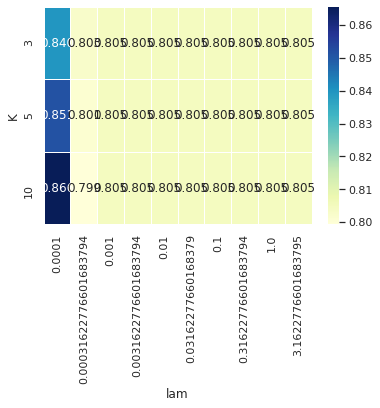

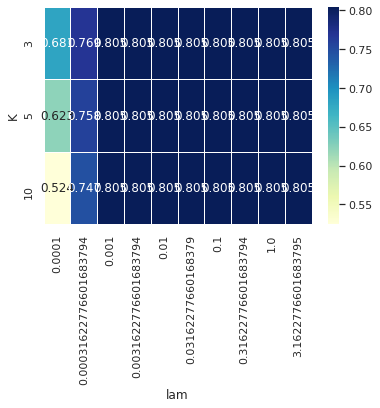

In [15]:
Ks, lams = [3, 5, 10], 10**np.arange(-4, 1, .5)
shiing_cv = LFM_CV(n_user, n_item, cv=3, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

In [16]:
## refit the best model with the full dataset
print(shiing_cv.best_model)
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing_best = LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing_best.fit(train_pair, train_rating_res)
pred_LFM = reg_rating + shiing_best.predict(test_pair)
print('RMSE for reg + LFM: %.3f' %rmse(test_rating, pred_LFM))

K             10.000000
lam            0.000316
train_rmse     0.746582
valid_rmse     0.799339
Name: 21, dtype: float64
Fitting Reg-LFM: K: 10, lam: 0.00032
Reg-LFM: ite: 0; diff: 0.759 RMSE: 0.777
Reg-LFM: ite: 1; diff: 0.014 RMSE: 0.788
Reg-LFM: ite: 2; diff: 0.000 RMSE: 0.788
Reg-LFM: ite: 3; diff: 0.002 RMSE: 0.786
Reg-LFM: ite: 4; diff: 0.002 RMSE: 0.784
Reg-LFM: ite: 5; diff: 0.002 RMSE: 0.782
Reg-LFM: ite: 6; diff: 0.002 RMSE: 0.781
Reg-LFM: ite: 7; diff: 0.001 RMSE: 0.780
Reg-LFM: ite: 8; diff: 0.001 RMSE: 0.779
Reg-LFM: ite: 9; diff: 0.001 RMSE: 0.779
RMSE for reg + LFM: 0.803


## Method 2: ``NCF`` Model based on side information

### Step 1: Formulate neural network based on continuous and categorical features
- embedding for categorical features
- concatenate continuous features and all embedding vectors

In [29]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, Flatten, Input, Dropout, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from IPython.display import SVG
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

In [30]:
class SideNCF(keras.Model):
    def __init__(self, num_users, num_movies, num_genre, embedding_size, **kwargs):
        super(SideNCF, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-2),
        )
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-2),
        )
        self.genre_embedding = layers.Embedding(
            num_genre,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-2),
        )
        self.concatenate = layers.Concatenate()
        self.dense1 = layers.Dense(100, name='fc-1', activation='relu')
        self.dense2 = layers.Dense(50, name='fc-2', activation='relu')
        self.dense3 = layers.Dense(1, name='fc-3', activation='relu')

    def call(self, inputs):
        cont_feats = inputs[0]
        cate_feats = inputs[1]
        user_vector = self.user_embedding(cate_feats[:,0])
        movie_vector = self.movie_embedding(cate_feats[:,1])
        genre_vector = self.genre_embedding(cate_feats[:,2])
        concatted_vec = self.concatenate([cont_feats, user_vector, movie_vector, genre_vector])
        fc_1 = self.dense1(concatted_vec)
        fc_2 = self.dense2(fc_1)
        fc_3 = self.dense3(fc_2)
        return fc_3

In [31]:
num_genre = movies_pd['pGenre'].max() + 1
model = SideNCF(num_users=n_user, num_movies=n_item, num_genre=num_genre, embedding_size=50)

metrics = [
    keras.metrics.MeanAbsoluteError(name='mae'),
    keras.metrics.RootMeanSquaredError(name='rmse')
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3), 
    loss=tf.keras.losses.MeanSquaredError(), 
    metrics=metrics
)

# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='model.png')

### Step 2: produce the continuous and categorical features for users and items

In [32]:
## find the continuous features and categorical features for user and item, respectively
movie_cont, movie_cate = ['rating_mean', 'rating_count'], ['movieId', 'pGenre']
user_cont, user_cate = ['rating_mean', 'rating_count'], ['userId']

train_cont_feats = np.hstack((user_pd.loc[train_pair[:,0]][user_cont], movies_pd.loc[train_pair[:,1]][movie_cont]))
train_cate_feats = np.hstack((user_pd.loc[train_pair[:,0]][user_cate], movies_pd.loc[train_pair[:,1]][movie_cate]))

test_cont_feats = np.hstack((user_pd.loc[test_pair[:,0]][user_cont], movies_pd.loc[test_pair[:,1]][movie_cont]))
test_cate_feats = np.hstack((user_pd.loc[test_pair[:,0]][user_cate], movies_pd.loc[test_pair[:,1]][movie_cate]))

### Step 3: Feed neural network with multi-source dataset

In [33]:
callbacks = [keras.callbacks.EarlyStopping( 
    monitor='val_rmse', min_delta=0, patience=5, verbose=1, 
    mode='auto', baseline=None, restore_best_weights=True)]

history = model.fit(
    x=[train_cont_feats, train_cate_feats],
    y=train_rating,
    batch_size=64,
    epochs=50,
    verbose=1,
    validation_split=.2,
)

Epoch 1/50
845/845 [==============================] - 4s 4ms/step - loss: 1.3824 - mae: 0.6958 - rmse: 0.9486 - val_loss: 0.8177 - val_mae: 0.6271 - val_rmse: 0.8215
Epoch 2/50
845/845 [==============================] - 3s 4ms/step - loss: 0.7459 - mae: 0.6155 - rmse: 0.8053 - val_loss: 0.7235 - val_mae: 0.6112 - val_rmse: 0.8093
Epoch 3/50
845/845 [==============================] - 3s 4ms/step - loss: 0.6987 - mae: 0.6090 - rmse: 0.7988 - val_loss: 0.6996 - val_mae: 0.6100 - val_rmse: 0.8045
Epoch 4/50
845/845 [==============================] - 3s 4ms/step - loss: 0.6799 - mae: 0.6047 - rmse: 0.7944 - val_loss: 0.7058 - val_mae: 0.6191 - val_rmse: 0.8117
Epoch 5/50
845/845 [==============================] - 3s 4ms/step - loss: 0.6720 - mae: 0.6035 - rmse: 0.7921 - val_loss: 0.6909 - val_mae: 0.6055 - val_rmse: 0.8054
Epoch 6/50
845/845 [==============================] - 3s 4ms/step - loss: 0.6650 - mae: 0.6007 - rmse: 0.7893 - val_loss: 0.6789 - val_mae: 0.6033 - val_rmse: 0.7998
Epoc

In [48]:
## make prediction
pred_rating = model.predict([test_cont_feats, test_cate_feats]).flatten()
print(pred_rating)
print('rmse: SideNCF: %.3f' %rmse(test_rating, pred_rating))

[2.9420114 3.3594353 2.0358317 ... 3.8942363 3.1720738 3.9475594]
rmse: LFactorNet: 0.882
